# 1D Burger's LaSDI-NM Example

In [1]:
import numpy as np
import numpy.linalg as LA

import matplotlib
import matplotlib.pyplot as plt
from itertools import product

import sys,time
import os
import pickle
import torch

sys.path.append("..") # Adds higher directory to python modules path.
import modLaSDIUtils as lasdiutils
import modAutoEncoder as autoencoder
from LaSDI import LaSDI

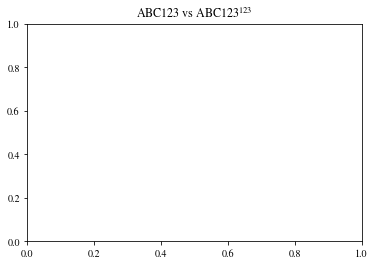

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.labelsize'] = 28
plt.rcParams['figure.dpi'] = 150

In [3]:
!nvidia-smi
torch.cuda.empty_cache()

/usr/bin/sh: 1: nvidia-smi: not found


### Load data and models produced from Build and Train files

In [4]:
# ### Load Data if Model Already Exists ###
snapshot_full = pickle.load(open("./data/snapshot_git.p", 'rb'))
snapshot_full = snapshot_full[:,:-1].astype('float32')
snapshot_full_FOM = pickle.load(open("./data/FOM.p",'rb'))
FOM_time = snapshot_full_FOM['time']
snapshot_full_FOM = snapshot_full_FOM['FOM'][:,:-1].astype('float32')


In [5]:
# Set print option
np.set_printoptions(threshold=sys.maxsize)

# Choose device that is not being used
gpu_ids = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = autoencoder.getDevice()
print("Using device:", device, '\n')

Using device: cpu 



In [6]:
# set encoder and decoder types, activation function, etc.
encoder_class = autoencoder.Encoder
decoder_class = autoencoder.Decoder
f_activation = autoencoder.SiLU

maxk = 10
convergence_threshold = 1.0e-8

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt)

m = 1000
f = 4
b = 36
db = 12
M2 = b + (m-1)*db
M1 = 2*m
mask = lasdiutils.create_mask_1d(m,b,db)

AE_fname = 'model/AE_git.tar'
encoder, decoder = autoencoder.readAEFromFile(  encoder_class,
                                                decoder_class,
                                                f_activation,
                                                mask,
                                                m, f, M1, M2,
                                                device,
                                                AE_fname )

Sparsity in 1000 by 12024 mask: 99.70%


### Generate latent-space trajectories from training data

In [7]:
amp_arr = np.array([.75,.85])
width_arr = np.array([.95,1.05])
P = list(product(amp_arr, width_arr))
P = np.array(P)
   
latent_space_SS = autoencoder.encodedSnapshots( encoder,
                                                snapshot_full,
                                                nt+1,
                                                device )

### Generate LaSDI-NM Model

(x0)' = 1.997 1 + 1.774 x0 + 0.450 x1 + -1.168 x2 + 3.359 x3
(x1)' = -6.108 1 + -3.380 x0 + -0.579 x1 + 1.759 x2 + -6.641 x3
(x2)' = 5.464 1 + 9.630 x0 + 2.032 x1 + -6.499 x2 + 17.242 x3
(x3)' = 1.369 1 + 2.552 x0 + 0.525 x1 + -1.681 x2 + 4.537 x3


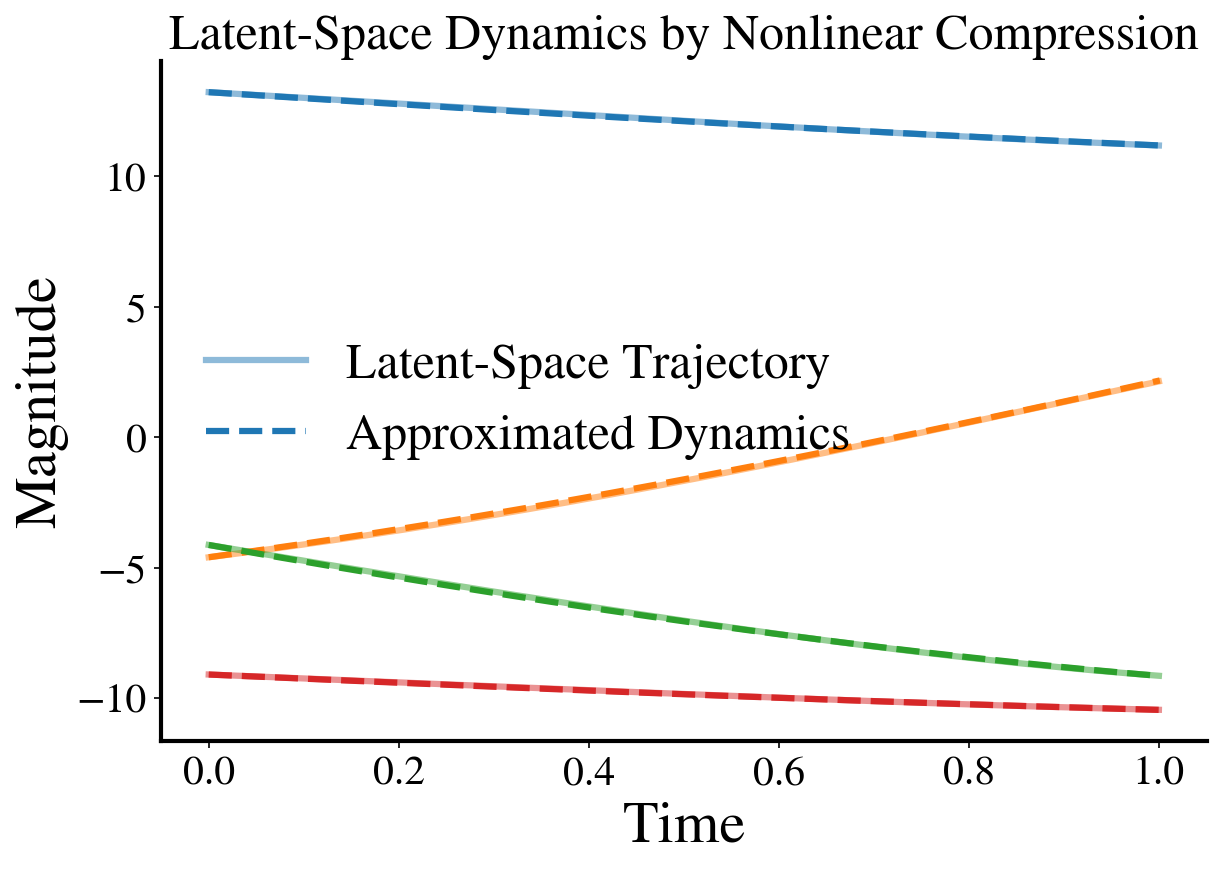

In [8]:
degree = 1
normal = 1
LaSDI_model = LaSDI(encoder, decoder, NN = True, device = device)
LaSDI_model.train_dynamics(latent_space_SS, P, dt)

### Generate ROM and visualize results

Final Position Error: 0.736%


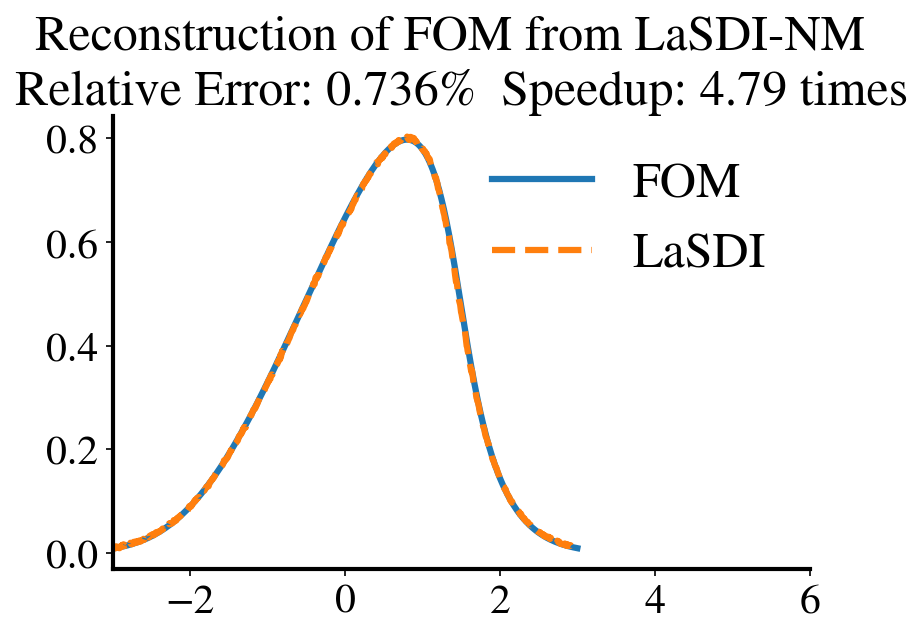

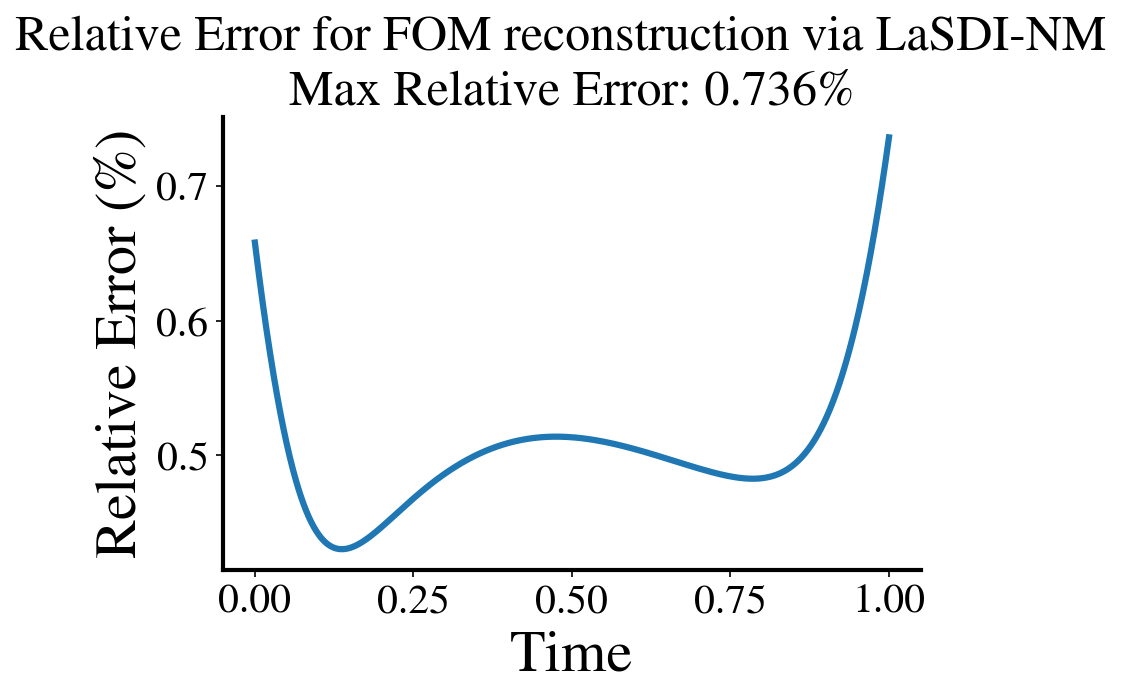

In [9]:
start = time.time()
FOM_recon = LaSDI_model.generate_ROM(snapshot_full_FOM[0], np.array([0.8,1.0]),t)
LaSDI_time = time.time()-start

print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM from LaSDI-NM', y = 1.05)
ax.set_title('Relative Error: {:.3}%  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100, FOM_time/LaSDI_time))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon[-1],'--', label = 'LaSDI')
ax.legend()
ax.set_xlim(-3,6)


FOM_re = np.empty(nt)
for i in range(nt):
    FOM_re[i] = LA.norm(FOM_recon[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
torch.cuda.empty_cache()